In [8]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.02f}'.format

<H1> Prepare Data </H1>

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/ekaratnida/Automated_Tools-/keep/cust_segment.csv", header=0)
print(df)

           CUST_CODE  TOTAL_SALES  TOTAL_VISIT
0     CUST0000000013       160.32           12
1     CUST0000000055       433.65           15
2     CUST0000000679        85.63           14
3     CUST0000001052       260.92           31
4     CUST0000001058        71.50            2
...              ...          ...          ...
4995  CUST0000998609        53.86           14
4996  CUST0000998851       394.92           23
4997  CUST0000998907      3721.02          177
4998  CUST0000999385      4252.77          313
4999  CUST0000999786       802.52          130

[5000 rows x 3 columns]


In [10]:
df.describe()

,TOTAL_SALES,TOTAL_VISIT
count,5000.00,5000.00
mean,967.00,78.06
std,1339.00,101.65
min,0.01,1.00
25%,60.05,6.00
50%,382.94,40.00
75%,1396.76,114.00
max,14684.06,926.00


<H1>Visualize distribution of variables

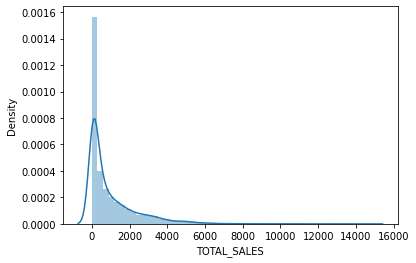

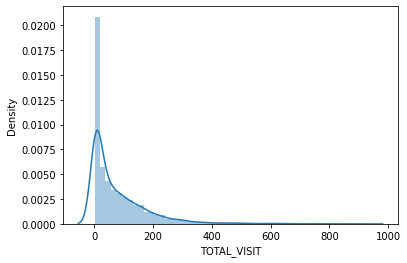

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


for i, col in enumerate(df.columns[1:]):
    plt.figure(i)
    sns.distplot(df[col])
    
plt.show()


In [12]:
# https://plotly.com/python/histograms/
import plotly.express as px
fig = px.histogram(df, x="TOTAL_SALES")
fig.show()

In [13]:
import plotly.express as px
fig = px.histogram(df, x="TOTAL_VISIT")
fig.show()

<H1> Standardize data

In [ ]:
from sklearn.preprocessing import StandardScaler #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

x = df[df.columns[1:]]
print("x = ",x)
m = StandardScaler().fit_transform(x)
print("m = ",m)
df_std = pd.DataFrame(m)
df_std.head(5)

In [24]:
import plotly.express as px
fig = px.scatter(x=df.TOTAL_SALES  , y=df.TOTAL_VISIT)
fig.show()

<H1> Find optimum k using elbow method

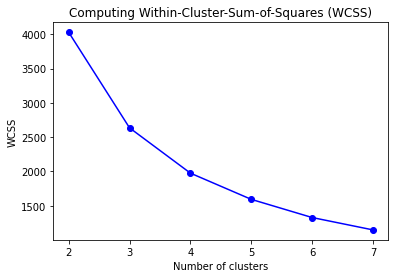

In [16]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(2, 8)
for i in N:
    model = KMeans(n_clusters=i) 
    model.fit_predict(df_std)
    wcss.append(model.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS)")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()


In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in N:

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_std)
    silhouette_avg = silhouette_score(df_std, cluster_labels)

    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    

For n_clusters = 2 The average silhouette_score is : 0.660551050342386
For n_clusters = 3 The average silhouette_score is : 0.6086291021846851
For n_clusters = 4 The average silhouette_score is : 0.5870995064343884
For n_clusters = 5 The average silhouette_score is : 0.5604484947852854
For n_clusters = 6 The average silhouette_score is : 0.5700417929715328
For n_clusters = 7 The average silhouette_score is : 0.5296356900147727


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

ss = []

for n_clusters in N:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_std) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_std)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_std, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_std, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

<H1> K-means clustering

In [21]:
cluster = KMeans(n_clusters=2)
df['cluster'] = cluster.fit_predict(df_std)
print(df)

           CUST_CODE  TOTAL_SALES  TOTAL_VISIT  cluster
0     CUST0000000013       160.32           12        0
1     CUST0000000055       433.65           15        0
2     CUST0000000679        85.63           14        0
3     CUST0000001052       260.92           31        0
4     CUST0000001058        71.50            2        0
...              ...          ...          ...      ...
4995  CUST0000998609        53.86           14        0
4996  CUST0000998851       394.92           23        0
4997  CUST0000998907      3721.02          177        1
4998  CUST0000999385      4252.77          313        1
4999  CUST0000999786       802.52          130        0

[5000 rows x 4 columns]


<H1> Determine average behaviors of each cluster </H1>

In [22]:
dfCluster = df.groupby('cluster', as_index=False).mean()
print(dfCluster)

dfCluster['NUM_CUST'] = df[['cluster','CUST_CODE']].groupby('cluster').count()
dfCluster

   cluster  TOTAL_SALES  TOTAL_VISIT
0        0       418.52        38.46
1        1      3015.51       225.98


,cluster,TOTAL_SALES,TOTAL_VISIT,NUM_CUST
0,0,418.52,38.46,3944
1,1,3015.51,225.98,1056


<H1> Visualize Clustering Results – Scatter Plot </H1>

<Figure size 432x288 with 0 Axes>

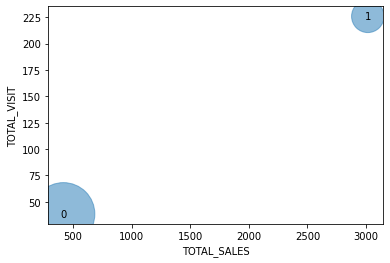

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['TOTAL_VISIT'], s=dfCluster['NUM_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("TOTAL_VISIT")

for i, txt in enumerate(dfCluster['cluster']):
    ax.annotate(txt, 
                (dfCluster['TOTAL_SALES'][i], 
                dfCluster["TOTAL_VISIT"][i]), 
                horizontalalignment='center',
                verticalalignment='center')

plt.show()


<H1>Visualize Clustering Results – Box Plot</H1>

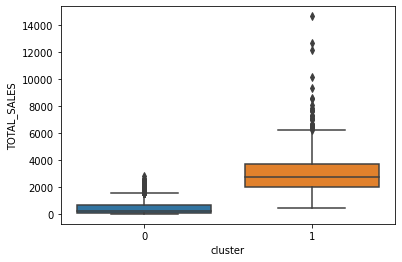

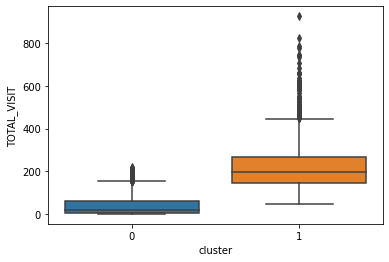

In [26]:
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df)
    plt.show()

In [32]:
import plotly.express as px
print(df.head())
for i, col in enumerate(df.columns[1:-1]):
  fig = px.box(df, x="cluster", y=col, points="all")
  fig.show()

        CUST_CODE  TOTAL_SALES  TOTAL_VISIT  cluster
0  CUST0000000013       160.32           12        0
1  CUST0000000055       433.65           15        0
2  CUST0000000679        85.63           14        0
3  CUST0000001052       260.92           31        0
4  CUST0000001058        71.50            2        0


# Exercise
### Dataset: https://raw.githubusercontent.com/ekaratnida/Applied-machine-learning/master/Week14-kmeans/Mall_Customers.csv

```python
one_hot_encoded_data = pd.get_dummies(data, columns = ['Gender'])
print(one_hot_encoded_data)
```